In [1]:
# Import packages to use
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams.update({'errorbar.capsize': 2})

//anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Define the file to explore
file05='resumen_N100_Niter3000000_beta0.5_dt1e-08_lf0.5_stf50_Nsimstot1368_mul10.csv'
file1='resumen_N100_Niter10000000_beta0.5_dt5e-08_lf1.0_stf50_Nsimstot1057_mul10.csv'
file2='resumen_N100_Niter2000000_beta0.5_dt1e-05_lf2.0_stf0_Nsimstot2000_mul10.csv'
file4='resumen_N100_Niter2000000_beta0.5_dt1e-05_lf4.0_stf0_Nsimstot2000_mul10.csv'
file8='resumen_N100_Niter2000000_beta0.5_dt1e-05_lf8.0_stf0_Nsimstot2000_mul10.csv'

# Define the parameters for the simulation
N=100
beta=0.5
nu=-1/(beta+1)

dt05=1e-8
dt1=5e-8
dt2=1e-5
dt4=1e-5
dt8=1e-5

# Import the data file
df05=pd.read_csv(file05, engine='python')
df1=pd.read_csv(file1, engine='python')
df2=pd.read_csv(file2, engine='python')
df4=pd.read_csv(file4, engine='python')
df8=pd.read_csv(file8, engine='python')

print(df2.columns.tolist())
print('Theoretical exponent (nu)= %g'%nu)

['t', 'log_t', 'N_avg', 'std_N', 'log_N']
Theoretical exponent (nu)= -0.666667


In [3]:
# We account for the fact that there are 50 initial simulations without fusion
# Therefore we substract 50*dt from the time and create a new data frame
# We take the data from the 6-th index onwards to erase negative times
df1_50=df1.copy()
df1_50['t']=df1_50['t']-50*dt1
df1_50=df1_50[6:]
# Recalculate log(t)
df1_50['log_t']=np.log(df1_50['t'])

df05_50=df05.copy()
df05_50['t']=df05_50['t']-50*dt05
df05_50=df05_50[6:]
# Recalculate log(t)
df05_50['log_t']=np.log(df05_50['t'])

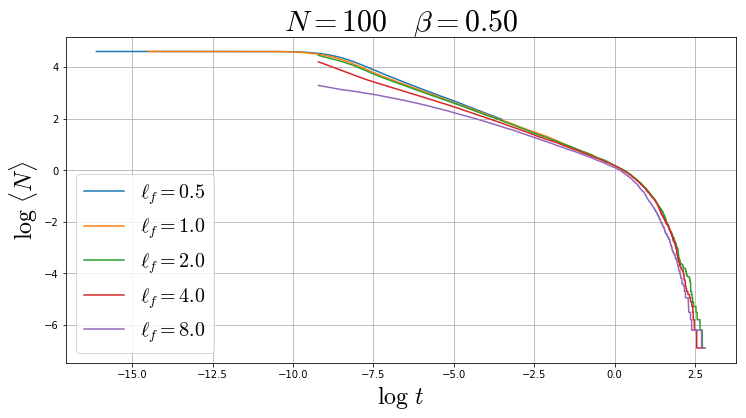

In [4]:
# Plot the entire log-data
# Plot the data 
plt.figure(figsize=(12,6))

plt.plot(df05_50.log_t,df05_50.log_N, label=r'$\ell_f=0.5$')
plt.plot(df1_50.log_t,df1_50.log_N, label=r'$\ell_f=1.0$')
plt.plot(df2.log_t,df2.log_N, label=r'$\ell_f=2.0$')
plt.plot(df4.log_t,df4.log_N, label=r'$\ell_f=4.0$')
plt.plot(df8.log_t,df8.log_N, label=r'$\ell_f=8.0$')

plt.xlabel(r'$\log \ t$',fontsize=24)
plt.ylabel(r'$\log \ \langle N \rangle $',fontsize=24)

plt.title(r'$N=%i \quad \beta=%.2f$'%(N,beta),fontsize=30)
plt.grid(zorder=3)
plt.legend(fontsize=20)
plt.show()
plt.close()